In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 100
pd.options.display.max_rows = 50

from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
train = pd.read_csv("C:/Users/kulka/Desktop/Others/Linear/Data/train_v9rqX0R.csv")
test  = pd.read_csv("C:/Users/kulka/Desktop/Others/Linear/Data/test_AbJTz2l.csv")

In [3]:
Submission = test[['Item_Identifier','Outlet_Identifier']]

In [4]:
train.shape, test.shape

((8523, 12), (5681, 11))

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [6]:
train.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

### EDA-Train Data

In [7]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [8]:
# Getting the number of unique values for each categorical variable, excluding the id variable.
for col in train.columns:
    if (train[col].dtype == "object") and (col !="Item_Identifier"):
        print ("Number of Unique Values in the {} variable are:{}".format(col,train[col].nunique()))

Number of Unique Values in the Item_Fat_Content variable are:5
Number of Unique Values in the Item_Type variable are:16
Number of Unique Values in the Outlet_Identifier variable are:10
Number of Unique Values in the Outlet_Size variable are:3
Number of Unique Values in the Outlet_Location_Type variable are:3
Number of Unique Values in the Outlet_Type variable are:4


In [9]:
# Getting the value_counts of the categorical variables,including the missing values
for col in train.columns:
    if (train[col].dtype == "object") and (col !="Item_Identifier"):
        print ("Number of Unique Values in the {} variable are:\n{}".format(col,train[col].value_counts(dropna=False)))
        print ("--------------------------------------------------------------")

Number of Unique Values in the Item_Fat_Content variable are:
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64
--------------------------------------------------------------
Number of Unique Values in the Item_Type variable are:
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64
--------------------------------------------------------------
Number of Unique Values in the Outlet_Identifier variable are:
OUT027    935
OUT013    932
OUT046    930
OUT049    930
OUT035    9

In [10]:
# Getting the numerical statistics like mean, median, std etc for continuous variables.
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


#### Dependent Variable - Item_Outlet_Sales

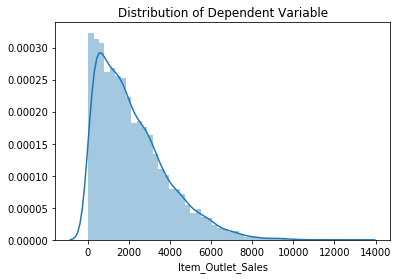

In [11]:
# Distribution of Dependent Variable.
sns.distplot(train['Item_Outlet_Sales']);
plt.title("Distribution of Dependent Variable");

This looks like a Positively Skewed Distribution.

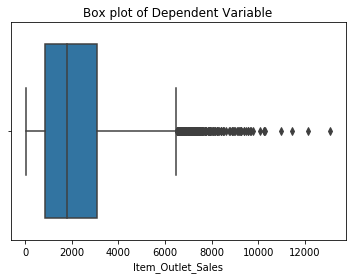

In [12]:
# Box plot of dependent variable, to check any outliers
sns.boxplot(train['Item_Outlet_Sales']);
plt.title("Box plot of Dependent Variable");

Looks like there are some large values, they may or may not be considered as outliers.

#### Independent Variables

In [13]:
train['Item_Weight'].describe()

count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64

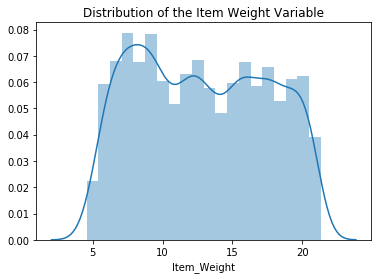

In [14]:
sns.distplot(train['Item_Weight']);
plt.title("Distribution of the Item Weight Variable");
# Looks like the variable has multiple peaks and majority of the values are between 5 and 20.

In [15]:
train['Item_Fat_Content'].value_counts(dropna=False)

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

Text(0, 0.5, 'Count')

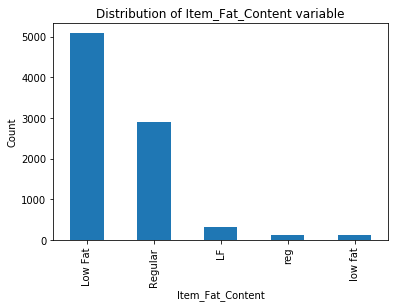

In [16]:
train['Item_Fat_Content'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of Item_Fat_Content variable");
plt.xlabel("Item_Fat_Content");
plt.ylabel("Count")
# Looks like Low Fat, low fat and LF mean the same and similarly reg is referring to Regular , this should be combined.
# Most of the items are of Low Fat Type

In [17]:
train['Item_Visibility'].describe()

count    8523.000000
mean        0.066132
std         0.051598
min         0.000000
25%         0.026989
50%         0.053931
75%         0.094585
max         0.328391
Name: Item_Visibility, dtype: float64

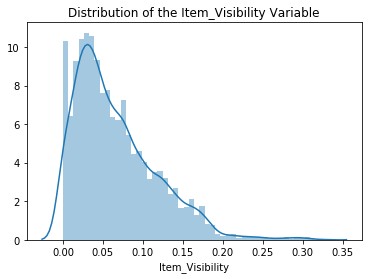

In [18]:
sns.distplot(train['Item_Visibility']);
plt.title("Distribution of the Item_Visibility Variable");
# This again looks like positively skewed distribution. Lot of values that are 0 which does not make sense. 

In [19]:
train['Item_Type'].value_counts(dropna=False)

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

Text(0, 0.5, 'Count')

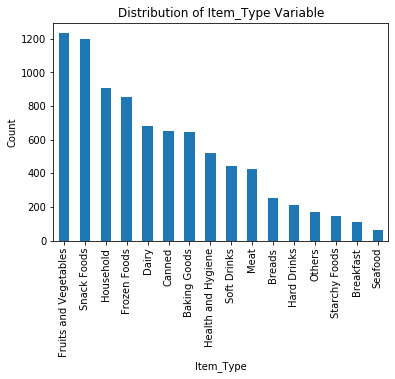

In [20]:
train['Item_Type'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of Item_Type Variable");
plt.xlabel("Item_Type");
plt.ylabel("Count")
# There are multiple categories here which may or may not be combined.

In [21]:
train['Item_MRP'].describe()

count    8523.000000
mean      140.992782
std        62.275067
min        31.290000
25%        93.826500
50%       143.012800
75%       185.643700
max       266.888400
Name: Item_MRP, dtype: float64

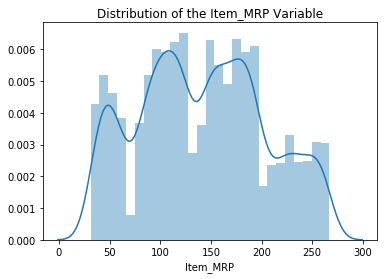

In [22]:
sns.distplot(train['Item_MRP']);
plt.title("Distribution of the Item_MRP Variable");
# This too looks not a m=normal plot and the values range from 31 to 266. There are a few groups within the MRP observed.

In [23]:
train['Outlet_Identifier'].value_counts(dropna=False)

OUT027    935
OUT013    932
OUT046    930
OUT049    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

Text(0, 0.5, 'Count')

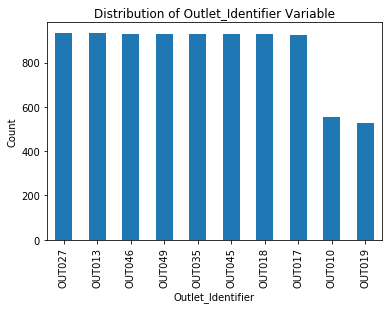

In [24]:
train['Outlet_Identifier'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of Outlet_Identifier Variable");
plt.xlabel("Outlet_Identifier");
plt.ylabel("Count")
# Most of the outlets have the same count except 2 which have lower count.

In [25]:
train['Outlet_Establishment_Year'].value_counts(dropna=False)

1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64

Text(0, 0.5, 'Count')

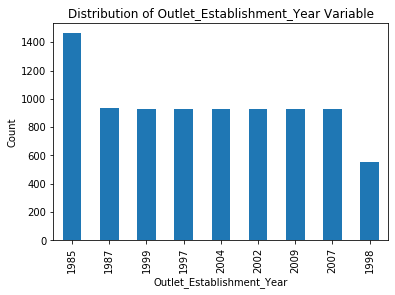

In [26]:
train['Outlet_Establishment_Year'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of Outlet_Establishment_Year Variable");
plt.xlabel("Outlet_Establishment_Year");
plt.ylabel("Count")
# Most of the outlets were established in the year 1985, we may not need the exact year, but the years of operation.

In [27]:
train['Outlet_Size'].value_counts(dropna=False)

Medium    2793
NaN       2410
Small     2388
High       932
Name: Outlet_Size, dtype: int64

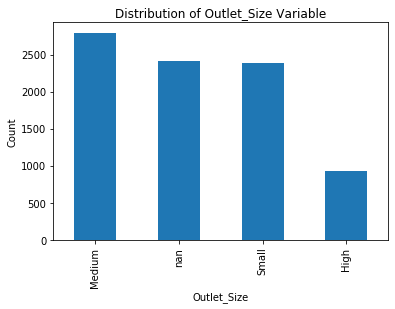

In [28]:
train['Outlet_Size'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of Outlet_Size Variable");
plt.xlabel("Outlet_Size");
plt.ylabel("Count");
# There are some missing values which need to be imputed either by creating a new category, or replacing with mode.

In [29]:
train['Outlet_Type'].value_counts(dropna=False)

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

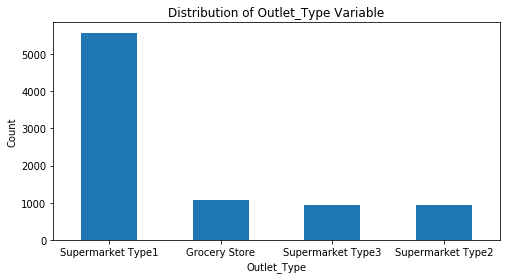

In [30]:
plt.figure(figsize=(8,4));
train['Outlet_Type'].value_counts(dropna=False).plot.bar();
plt.title("Distribution of Outlet_Type Variable");
plt.xlabel("Outlet_Type");
plt.ylabel("Count");
plt.xticks(rotation=360);
# Most of the outlets are of the type Supermarket Type-1 and the other types have almost the same count.

#### Bi-Variate Analysis

In [31]:
df = pd.crosstab(index=train['Item_Type'],columns=train['Item_Fat_Content'])
df.style.background_gradient(cmap='Reds')
# We can see that majority of snack foods have low fat and so do Fruits and Vegetables, Soft Drinks, 
# Majority of Meat have regular fat.

Item_Fat_Content,LF,Low Fat,Regular,low fat,reg
Item_Type,,,,,
Baking Goods,20,301,306,8,13
Breads,8,126,108,6,3
Breakfast,2,39,67,0,2
Canned,17,314,297,10,11
Dairy,24,382,258,12,6
Frozen Foods,22,424,387,4,19
Fruits and Vegetables,39,580,577,11,25
Hard Drinks,8,199,0,7,0
Health and Hygiene,29,481,0,10,0


In [32]:
df = pd.crosstab(index=train['Outlet_Size'],columns=train['Outlet_Type'])
df.style.background_gradient(cmap='Reds')
# We can see that almost all of the Outlets with high size are of the type Sepermarket Type 1.
# We can see that Medium sized outlets do not have grocery stores. 
# Small sized outlets are of Grocery and Supermarket Type1.

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,,,,
High,0,932,0,0
Medium,0,930,928,935
Small,528,1860,0,0


In [33]:
df = pd.crosstab(index=train['Outlet_Location_Type'],columns=train['Outlet_Type'])
df.style.background_gradient(cmap='Reds')
# Tier 1 cities have Grocery and Supermarket Type 1.
# Tier 2 cities have only Supermarket Type 1.
# Tier 3 cities have all the types of Outlets

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Location_Type,,,,
Tier 1,528,1860,0,0
Tier 2,0,2785,0,0
Tier 3,555,932,928,935


In [34]:
df = pd.crosstab(index=train['Outlet_Location_Type'],columns=train['Outlet_Size'])
df.style.background_gradient(cmap='Reds')
# Tier 1 cities have Medium and Small outlets
# Tier 2 cities have Only Small sized outlets
# Tier 3 citis do not have Small outlets.

Outlet_Size,High,Medium,Small
Outlet_Location_Type,,,
Tier 1,0,930,1458
Tier 2,0,0,930
Tier 3,932,1863,0


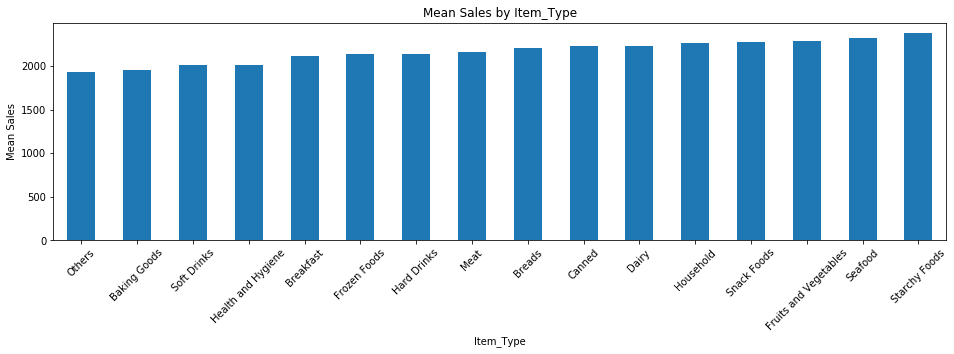

In [35]:
plt.figure(figsize=(16,4));
train.groupby("Item_Type")['Item_Outlet_Sales'].mean().sort_values().plot.bar();
plt.title("Mean Sales by Item_Type");
plt.xlabel("Item_Type");
plt.ylabel("Mean Sales");
plt.xticks(rotation=45);
# We can see that there is not substantial difference in the mean sales between the Item_Types.

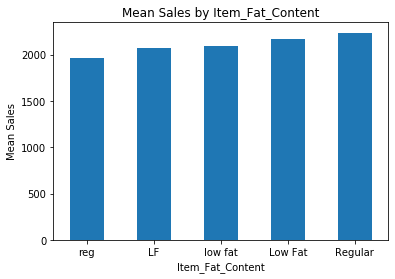

In [36]:
train.groupby("Item_Fat_Content")['Item_Outlet_Sales'].mean().sort_values().plot.bar();
plt.title("Mean Sales by Item_Fat_Content");
plt.xlabel("Item_Fat_Content");
plt.ylabel("Mean Sales");
plt.xticks(rotation=360);
# Now that the values in the Item_Fat_Countent are not combined, the difference may not appear big.

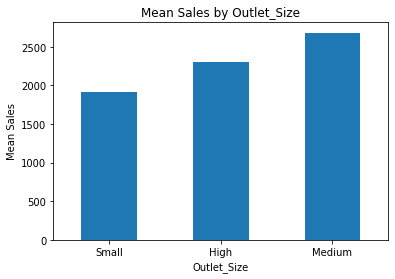

In [37]:
train.groupby("Outlet_Size")['Item_Outlet_Sales'].mean().sort_values().plot.bar();
plt.title("Mean Sales by Outlet_Size");
plt.xlabel("Outlet_Size");
plt.ylabel("Mean Sales");
plt.xticks(rotation=360);
# We can see that Medium outlets have migher mean sales as compared to High and small sized outlets.

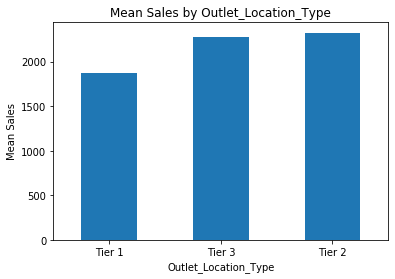

In [38]:
train.groupby("Outlet_Location_Type")['Item_Outlet_Sales'].mean().sort_values().plot.bar();
plt.title("Mean Sales by Outlet_Location_Type");
plt.xlabel("Outlet_Location_Type");
plt.ylabel("Mean Sales");
plt.xticks(rotation=360);
# We can see that Ouelets in Tier 2 and Tier 3 cities have almost same Mean Sales as compared to Tier  cities.

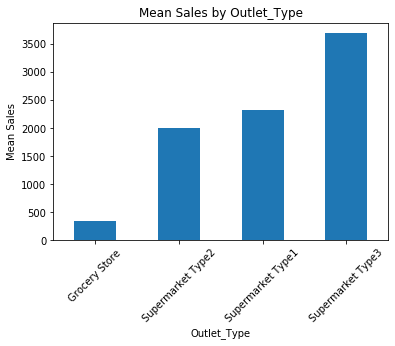

In [39]:
train.groupby("Outlet_Type")['Item_Outlet_Sales'].mean().sort_values().plot.bar();
plt.title("Mean Sales by Outlet_Type");
plt.xlabel("Outlet_Type");
plt.ylabel("Mean Sales");
plt.xticks(rotation=45);
# We can see that Supermarket Type 3 have highest mean sales and Grocery Stores have lowest. 
# Not a substantial difference between Supermarket Type 2 and Type 1 mean sales.

#### Correlation

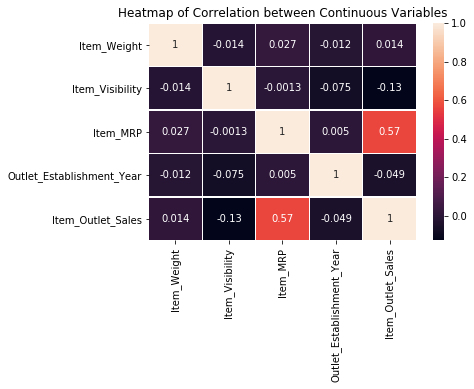

In [40]:
sns.heatmap(train.corr(),annot=True,linewidths=0.25);
plt.title("Heatmap of Correlation between Continuous Variables");

Few things to note from the above correlation plot,
1. Only Item_MRP has high correlation with the dependent variable (Not Very High though).
2. None of the independent variables are highly correlated with each other, which rules out the Multicollinearity between independent variables. 
3. Item_Visibility and Outlet_Establishment_Year are negatively correlated with the dependent variable.

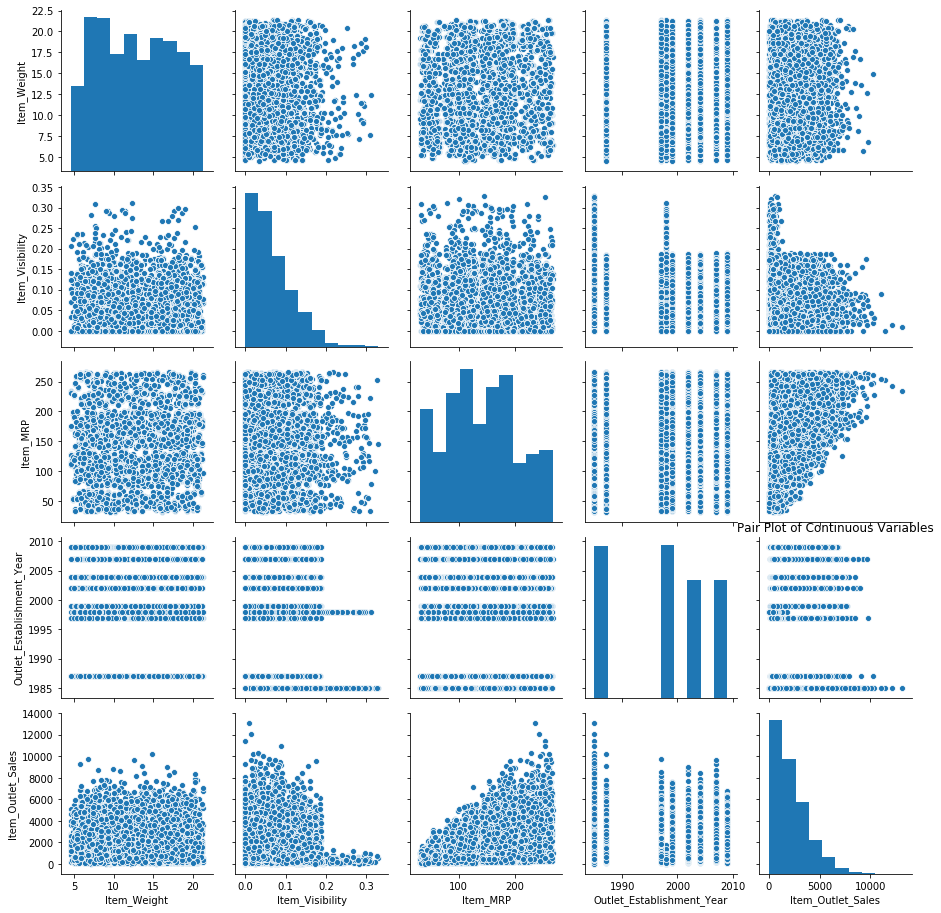

In [41]:
sns.pairplot(train);
plt.title("Pair Plot of Continuous Variables");

1. We can see from the above pair plot that Only Item_MRP seems to be strong relationship with dependent variable.

## Feature Generation (Modification)

In [42]:
# The following piece of code replaces the repeated values in the Item_Fat_Content Variable, replaces the 0's in Item_Visibility
# replaces the missing values in Item_Weight variable, and replaces missing values in Outlet_Size with "Missing" so that it is 
# considered as a separate category, extracts the first two letters of Item_Identifier variable, calculates the number of years
# an outlet is running. 
for df in [train,test]:
    df['Item_Fat_Content'].replace({"Low Fat":"Low_Fat","LF":"Low_Fat","low fat":"Low_Fat","reg":"Regular"},inplace=True)
    df['Item_Visibility'].replace({0:df['Item_Visibility'].mean()},inplace=True)
    df['Item_Weight'].fillna(df['Item_Weight'].median(),inplace=True)
    df['Outlet_Size'].fillna("Missing",inplace=True)
    df['Item_Identifier'] = df['Item_Identifier'].apply(lambda x: x[:2])
    df['Outlet_Establishment_Year'] = 2020 - df['Outlet_Establishment_Year']

In [43]:
# The following code creates grouped statistics and joins it with the main data frame (train). 
agg_func = {
    'Item_MRP': ['mean','median','std']    
}
agg_func = train.groupby('Item_Fat_Content').agg(agg_func)
agg_func.columns = [ 'Item_Fat_Content_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
train = train.merge(agg_func, on=['Item_Fat_Content'], how='left')

agg_func = {
    'Item_MRP': ['mean','median','std']    
}
agg_func = train.groupby('Item_Identifier').agg(agg_func)
agg_func.columns = [ 'Item_Identifier_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
train = train.merge(agg_func, on=['Item_Identifier'], how='left')

agg_func = {
    'Item_MRP': ['mean','median','std']    
}
agg_func = train.groupby('Item_Type').agg(agg_func)
agg_func.columns = [ 'Item_Type_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
train = train.merge(agg_func, on=['Item_Type'], how='left')

In [44]:
# The following code creates grouped statistics and joins it with the main data frame (test).
agg_func = {
    'Item_MRP': ['mean','median','std']    
}
agg_func = test.groupby('Item_Fat_Content').agg(agg_func)
agg_func.columns = [ 'Item_Fat_Content_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
test = test.merge(agg_func, on=['Item_Fat_Content'], how='left')

agg_func = {
    'Item_MRP': ['mean','median','std']    
}
agg_func = test.groupby('Item_Identifier').agg(agg_func)
agg_func.columns = [ 'Item_Identifier_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
test = test.merge(agg_func, on=['Item_Identifier'], how='left')

agg_func = {
    'Item_MRP': ['mean','median','std']    
}
agg_func = test.groupby('Item_Type').agg(agg_func)
agg_func.columns = [ 'Item_Type_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
test = test.merge(agg_func, on=['Item_Type'], how='left')

The thinking behind creating so many grouped features is to explain what creating large number of eatures with less training points (Such as this example) does to the model in terms or Overfitting. This will also help to explain the variants of Linear Regression such as Ridge Regression and Lasso Regression which account for Regularization which in turn reduces the model complexity and gives better results.

One should also note that not all the features that are generated will have higher importance with the dependent variable.

In [45]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [46]:
# Separating the features from the target variable
X = train[[col for col in train.columns if col!="Item_Outlet_Sales"]]
y = train['Item_Outlet_Sales']

In [47]:
# Creating train, test split for training the model on train data and testing it on the test data.
X_Train, X_Test, y_Train, y_Test = train_test_split(X,y,test_size=0.25,random_state=42)
print (X_Train.shape)
print (y_Train.shape)
print (X_Test.shape)
print (y_Test.shape)

(6392, 55)
(6392,)
(2131, 55)
(2131,)


#### Model Building

1. There are basically two ways or running a Linear Regression in Python, first one is using the scikit learn library which is more popular and more robust, but the disadvantage is that it does not give the output in a desired format, for example, it does not readily give you the p-values, t-statistic, vif values etc etc once the model is built.

2. Because of the above mentioned disadvantages, one can also use the statsmodels library to run a linear regression model which gives all the desired results in a single format, but it is not that robust and the API is not that user friendly like scikit learn.

In [48]:
# Fitting a basic linear regression model(without cross validation) using scikit learn.
LR = LinearRegression(n_jobs=-1)
LR.fit(X_Train,y_Train)
train_predictions_LR = LR.predict(X_Train)
test_predictions_LR = LR.predict(X_Test)
predictions = LR.predict(X)
print ("Training RMSE is {}".format(np.sqrt(mean_squared_error(y_Train,train_predictions_LR))))
print ("Training R-Squared is {}".format(r2_score(y_Train,train_predictions_LR)))
print ("--------------------------------------------")
print ("Testing RMSE is {}".format(np.sqrt(mean_squared_error(y_Test,test_predictions_LR))))
print ("Testing R-Squared is {}".format(r2_score(y_Test,test_predictions_LR)))

Training RMSE is 1139.2193101498349
Training R-Squared is 0.5614664430918097
--------------------------------------------
Testing RMSE is 1092.6362849600425
Testing R-Squared is 0.5672838422818698


#### Cross Validation

In [49]:
# Running a 5 fold cross validation using the model we just built. 
cv= np.sqrt(-(np.array(cross_val_score(LR,X,y,cv=5,n_jobs=-1,scoring="neg_mean_squared_error"))))

In [50]:
print ("Min Cross Validation RMSE: {}".format(np.min(cv)))
print ("Max Cross Validation RMSE: {}".format(np.max(cv)))
print ("Mean Cross Validation RMSE: {}".format(np.mean(cv)))
print ("Median Cross Validation RMSE: {}".format(np.median(cv)))
print ("std Cross Validation RMSE: {}".format(np.std(cv)))

Min Cross Validation RMSE: 1115.1954674501133
Max Cross Validation RMSE: 1152.9620283901502
Mean Cross Validation RMSE: 1132.7902218692082
Median Cross Validation RMSE: 1129.6728419932488
std Cross Validation RMSE: 13.599769674548265


In [51]:
# We can see that the mean CV RMSE is just a little better than the training set RMSE and is worse than the test set RMSE.

#### Feature Importance

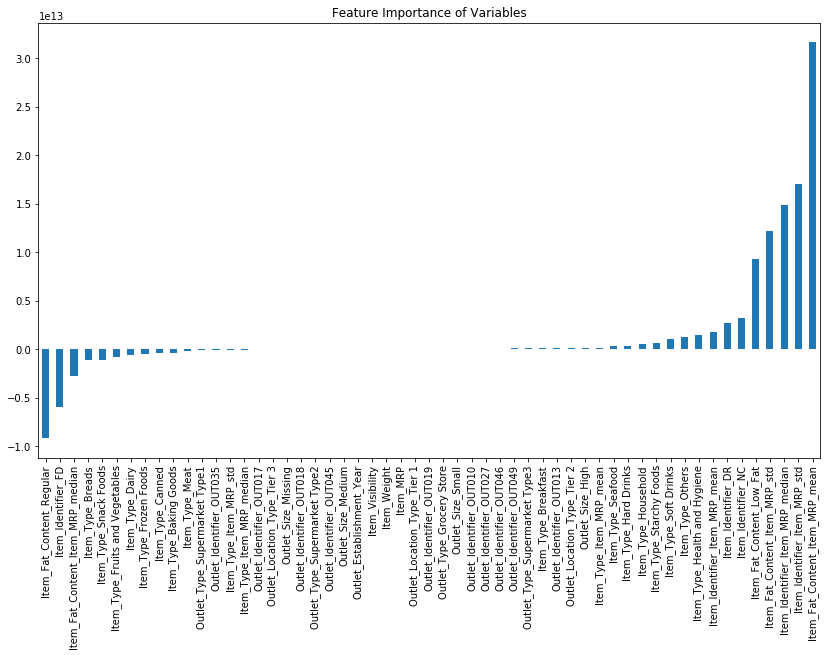

In [52]:
plt.figure(figsize=(14,8))
ser = pd.Series(LR.coef_,X_Train.columns).sort_values();
ser.plot(kind='bar');
plt.title("Feature Importance of Variables");
# We can see that some feature have high importance as compared to others, this usually leads to overfitting, this should be checked.

#### Using Statsmodels to build the model.

In [53]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [54]:
X = train[[col for col in train.columns if col!="Item_Outlet_Sales"]]
y = train['Item_Outlet_Sales']

In [55]:
X = sm.add_constant(X) # adding a constant

In [56]:
model = sm.OLS(y, X).fit()

In [57]:
model.summary()
# We can see that we got a poor R Squared and Adjusted R Squared values. 
# We can also see from the P values that Item_MRP seem to be the only important variable with a 5% significance level.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     378.4
Date:                Mon, 03 Aug 2020   Prob (F-statistic):               0.00
Time:                        13:30:32   Log-Likelihood:                -71988.
No. Observations:                8523   AIC:                         1.440e+05
Df Residuals:                    8493   BIC:                         1.442e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                            -9.969e+08   4.07e+09     -0.245      0.807   -8.98e+09    6.99e+09
Item_Weight                         -0.5307      2.915     -0.182      0.856      -6.246       5.184
Item_Visibility                   -235.0007    264.859     -0.887      0.375    -754.188     284.187
Item_MRP                            15.5716      0.198     78.561      0.000      15.183      15.960
Outlet_Establishment_Year        -2.538e+07   1.04e+08     -0.245      0.807   -2.29e+08    1.78e+08
Item_Fat_Content_Item_MRP_mean   -2.447e+12      1e+13     -0.245      0.807    -2.2e+13    1.72e+13
Item_Fat_Content_Item_MRP_median  7.153e+11   2.92e+12      0.245      0.807   -5.01e+12    6.44e+12
Item_Fat_Content_Item_MRP_std     1.596e+12   6.52e+12      0.245      0.807   -1.12e+13    1.44e+13
Item_Identifier_Item_MRP_mean     4.211e+10   1.72e+11      0.245      0.807   -2.95e+11    3.79e+11
Item_Identifier_Item_MRP_median   8.003e+11   3.27e+12      0.245      0.807   -5.61e+12    7.21e+12
Item_Identifier_Item_MRP_std      3.759e+11   1.54e+12      0.245      0.807   -2.63e+12    3.39e+12
Item_Type_Item_MRP_mean           1.018e+09   4.16e+09      0.245      0.807   -7.14e+09    9.17e+09
Item_Type_Item_MRP_median        -5.615e+08   2.29e+09     -0.245      0.807   -5.06e+09    3.93e+09
Item_Type_Item_MRP_std           -2.015e+09   8.23e+09     -0.245      0.807   -1.82e+10    1.41e+10
Item_Identifier_DR               -5.261e+10   2.15e+11     -0.245      0.807   -4.74e+11    3.69e+11
Item_Identifier_FD               -5.282e+10   2.16e+11     -0.245      0.807   -4.76e+11     3.7e+11
Item_Identifier_NC                1.031e+11   4.21e+11      0.245      0.807   -7.22e+11    9.28e+11
Item_Fat_Content_Low_Fat         -3.428e+11    1.4e+12     -0.245      0.807   -3.09e+12     2.4e+12
Item_Fat_Content_Regular          3.414e+11   1.39e+12      0.245      0.807   -2.39e+12    3.08e+12
Item_Type_Baking Goods           -1.921e+10   7.85e+10     -0.245      0.807   -1.73e+11    1.35e+11
Item_Type_Breads                 -1.367e+10   5.58e+10     -0.245      0.807   -1.23e+11    9.58e+10
Item_Type_Breakfast               -9.95e+09   4.06e+10     -0.245      0.807   -8.96e+10    6.97e+10
Item_Type_Canned                 -1.169e+10   4.77e+10     -0.245      0.807   -1.05e+11    8.19e+10
Item_Type_Dairy                   2.745e+09   1.12e+10      0.245      0.807   -1.92e+10    2.47e+10
Item_Type_Frozen Foods           -3.472e+09   1.42e+10     -0.245      0.807   -3.13e+10    2.43e+10
Item_Type_Fruits and Vegetables  -1.424e+10   5.82e+10     -0.245      0.807   -1.28e+11    9.98e+10
Item_Type_Hard Drinks            -3.817e+09   1.56e+10     -0.245      0.807   -3.44e+10    2.68e+10
Item_Type_Health and Hygiene      3.451e+10   1.41e+1

### Checking Regression Assumptions with Plots

##### Checking Homoskedasticity with Residuals Vs Fitted plot

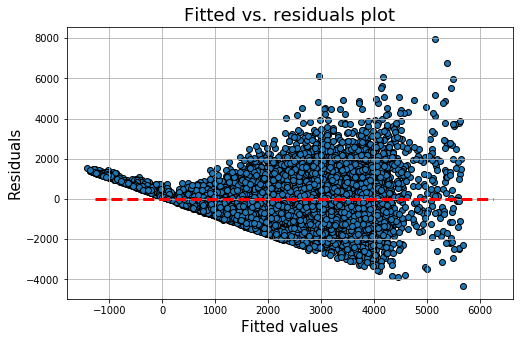

In [58]:
plt.figure(figsize=(8,5))
p=plt.scatter(x=model.fittedvalues,y=model.resid,edgecolor='k')
xmin=min(model.fittedvalues)
xmax = max(model.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

1. We can see that the above plot show s a funnel type pattern which explains a non constant variance. This also indicates that the variance is not constant. This might be due to the presence of outliers or too large values. 

##### Checking Normality of Residuals with Q-Q plots And Histogram

In [60]:
from statsmodels.graphics.gofplots import qqplot

<Figure size 576x360 with 0 Axes>

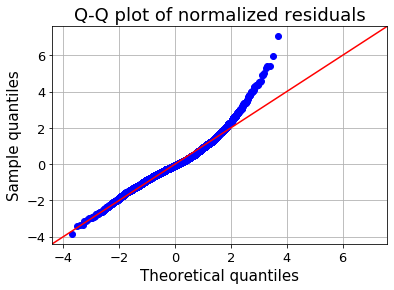

In [61]:
plt.figure(figsize=(8,5))
fig=qqplot(model.resid_pearson,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalized residuals",fontsize=18)
plt.grid(True)
plt.show()

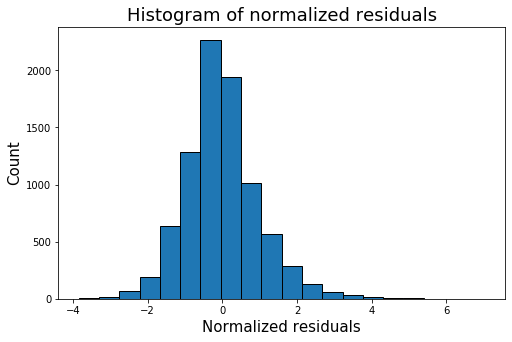

In [62]:
plt.figure(figsize=(8,5))
plt.hist(model.resid_pearson,bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalized residuals',fontsize=15)
plt.title("Histogram of normalized residuals",fontsize=18)
plt.show()

1. We can see that not all the points lie on the normal line from the plot above. This indicates that the error terms are not normally distributed. This might indicate the presence of some unusual points which need to be studied. There is some deviation from the normality.

##### Checking Multicollinearity with VIF (Variation Inflation Factor)

In [63]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [67]:
for i in range(len(X.columns[:-1])):
    v=vif(np.matrix(X[:-1]),i)
    print("Variance inflation factor for {}: {}".format(X.columns[i],round(v,2)))

C:\Users\kulka\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Variance inflation factor for const: 0.0
Variance inflation factor for Item_Weight: 1.02
Variance inflation factor for Item_Visibility: 1.11
Variance inflation factor for Item_MRP: 1.02
Variance inflation factor for Outlet_Establishment_Year: 59190.72
Variance inflation factor for Item_Fat_Content_Item_MRP_mean: 3.2
Variance inflation factor for Item_Fat_Content_Item_MRP_median: 465984.73
Variance inflation factor for Item_Fat_Content_Item_MRP_std: 0.07
Variance inflation factor for Item_Identifier_Item_MRP_mean: 160.28
Variance inflation factor for Item_Identifier_Item_MRP_median: 13.68
Variance inflation factor for Item_Identifier_Item_MRP_std: 453.11
Variance inflation factor for Item_Type_Item_MRP_mean: 138.81
Variance inflation factor for Item_Type_Item_MRP_median: 25121.92
Variance inflation factor for Item_Type_Item_MRP_std: 3284.91
Variance inflation factor for Item_Identifier_DR: 104200544356.74
Variance inflation factor for Item_Identifier_FD: 32616.15
Variance inflation fact

1. So there is a thumb rule that the VIF should be Less than 4 for no multicolleniarity to exist and here we can see some values that are way above that value. There is some serious multicolleniarity here. This should be corrected. 

#### Regularization

We need regularization for the following reasons,

1. To reduce model complexity (aka, reducing the coeffieients of the model).
2. We need regularization so that the model does not overfit the training data. 

In Regularization, we basically add an additional term to the Cost function which acts as a penalty in case the model is overfitting or the coefficients are too high. There are basically two types of Regularization, 

1. Ridge Regression: This type of regression reduces the coefficients value so that one or two variables do not impact the model so much. One should also note that this does not act as a Feature Selection mechanism in which case the coefficients are reduced to zero thus removing the variable. 
2. LASSO Regression: LASSO stands for Least Absolute Shrinkage Selector Operator, as the name suggests, this type of regression reduces the model coefficients to zero, thus removing them from the model. This acts as a Feature Selection mechanism. 

#### LASSO Regression

Since our model has a lot of variables, we will have to fetch the important ones from it. Hence we can use LASSO in the beginning and then use Ridge to reduce the model coefficients. 

In [72]:
lasso_regression = Lasso(alpha=0.5, normalize=True)

In [73]:
lasso_regression.fit(X_Train,y_Train)

Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [75]:
train_predict = lasso_regression.predict(X_Train)
test_predict = lasso_regression.predict(X_Test)
print ("Training RMSE:",np.sqrt(mean_squared_error(y_Train,train_predict)))
print ("Training R Squared:",r2_score(y_Train,train_predict))
print ("--------------------------------------------------------")
print ("Testing RMSE:",np.sqrt(mean_squared_error(y_Test,test_predict)))
print ("Testing R Squared:",r2_score(y_Test,test_predict))

Training RMSE: 1139.3585012099477
Training R Squared: 0.5613592755269674
--------------------------------------------------------
Testing RMSE: 1091.5064184196453
Testing R Squared: 0.568178300446099


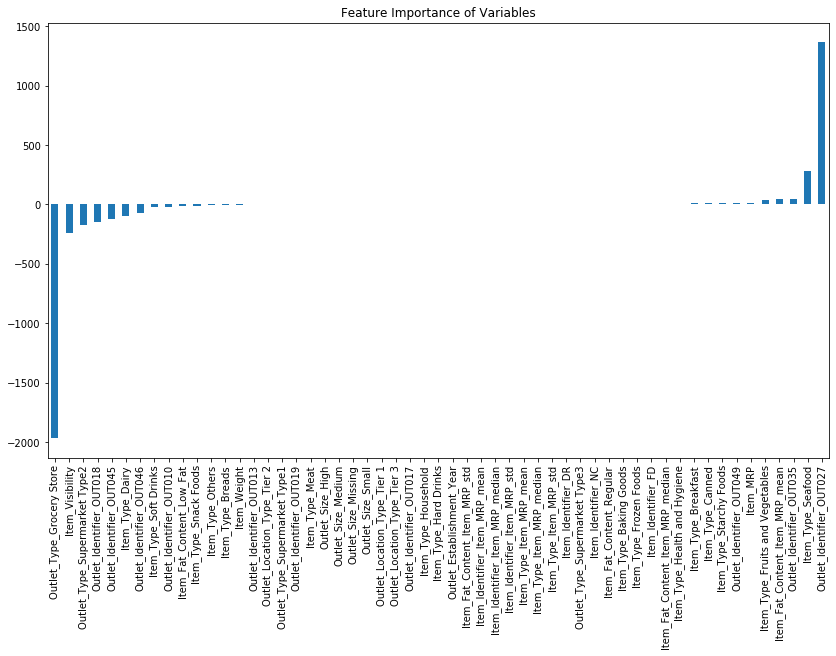

In [77]:
plt.figure(figsize=(14,8))
ser = pd.Series(lasso_regression.coef_,X_Train.columns).sort_values();
ser.plot(kind='bar');
plt.title("Feature Importance of Variables");
# We can see that for a number of variables, the coefficient has been reduced to absolute 0, we can vary the value of alpha
# and notice different results. 

In [80]:
alpha = [0.05,0.01,0.1,0.3,0.5,1]
for i in alpha:
    print ("Value of Alpha is:",i)
    lasso_reg = Lasso(alpha=i,normalize=True)
    lasso_reg.fit(X_Train,y_Train)
    print ("For {} alpha, the training RMSE is:{}".format(i,np.sqrt(mean_squared_error(y_Train,lasso_reg.predict(X_Train)))))
    print ("For {} alpha, the testing RMSE is:{}".format(i,np.sqrt(mean_squared_error(y_Test,lasso_reg.predict(X_Test)))))
    print ("--------------------------------------------------")

Value of Alpha is: 0.05
For 0.05 alpha, the training RMSE is:1139.3585012099477
For 0.05 alpha, the testing RMSE is:1091.5064184196453
--------------------------------------------------
Value of Alpha is: 0.01


C:\Users\kulka\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16047247.840338707, tolerance: 1891684.0863333764
  positive)


For 0.01 alpha, the training RMSE is:1139.2123088289693
For 0.01 alpha, the testing RMSE is:1092.4094198618466
--------------------------------------------------
Value of Alpha is: 0.1
For 0.1 alpha, the training RMSE is:1139.7177292188303
For 0.1 alpha, the testing RMSE is:1090.751260953314
--------------------------------------------------
Value of Alpha is: 0.3
For 0.3 alpha, the training RMSE is:1142.1742620686018
For 0.3 alpha, the testing RMSE is:1090.3814500268318
--------------------------------------------------
Value of Alpha is: 0.5
For 0.5 alpha, the training RMSE is:1144.7065354843746
For 0.5 alpha, the testing RMSE is:1092.1165044125255
--------------------------------------------------
Value of Alpha is: 1
For 1 alpha, the training RMSE is:1152.7748853073006
For 1 alpha, the testing RMSE is:1099.5079879817317
--------------------------------------------------


1. We can see that the testing RMSE decreases slightly until some point (till alpha is 0.3), and starts increasing again as we increase the value of alpha. This value of alpha should be decided using Cross Valudation. 

#### Ridge Regression

Ridge Regression is mostly used when the model coefficients are very high resulting in the complex models. It basically reduces the magnitude of the coefficients by imposing heavy penalty.

In [81]:
ridge_reg = Ridge(alpha=0.01,normalize=True)

In [82]:
ridge_reg.fit(X_Train,y_Train)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=0.001)

In [83]:
train_predict = ridge_reg.predict(X_Train)
test_predict = ridge_reg.predict(X_Test)
print ("Training RMSE:",np.sqrt(mean_squared_error(y_Train,train_predict)))
print ("Training R Squared:",r2_score(y_Train,train_predict))
print ("--------------------------------------------------------")
print ("Testing RMSE:",np.sqrt(mean_squared_error(y_Test,test_predict)))
print ("Testing R Squared:",r2_score(y_Test,test_predict))

Training RMSE: 1139.2527633704917
Training R Squared: 0.5614406876027449
--------------------------------------------------------
Testing RMSE: 1092.3457570516268
Testing R Squared: 0.5675139269097489


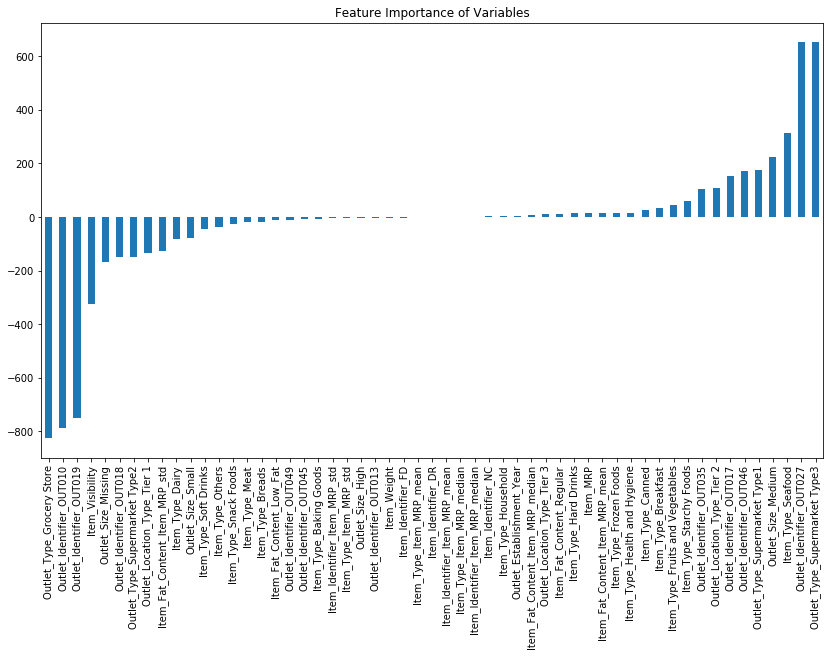

In [85]:
plt.figure(figsize=(14,8))
ser = pd.Series(ridge_reg.coef_,X_Train.columns).sort_values();
ser.plot(kind='bar');
plt.title("Feature Importance of Variables");
# We can see that for a number of variables, the coefficient has been reduced , but not to absolute 0. The magnitude of the
# coefficients has been reduced.

In [87]:
alpha = [0.01,0.03,0.05,0.01,0.1,0.3,0.5,1]
for i in alpha:
    print ("Value of Alpha is:",i)
    ridge_reg = Ridge(alpha=i,normalize=True)
    ridge_reg.fit(X_Train,y_Train)
    print ("For {} alpha, the training RMSE is:{}".format(i,np.sqrt(mean_squared_error(y_Train,ridge_reg.predict(X_Train)))))
    print ("For {} alpha, the testing RMSE is:{}".format(i,np.sqrt(mean_squared_error(y_Test,ridge_reg.predict(X_Test)))))
    print ("--------------------------------------------------")

Value of Alpha is: 0.01
For 0.01 alpha, the training RMSE is:1139.2527633704917
For 0.01 alpha, the testing RMSE is:1092.3457570516268
--------------------------------------------------
Value of Alpha is: 0.03
For 0.03 alpha, the training RMSE is:1139.6214436185824
For 0.03 alpha, the testing RMSE is:1091.9772632649301
--------------------------------------------------
Value of Alpha is: 0.05
For 0.05 alpha, the training RMSE is:1140.3184456876675
For 0.05 alpha, the testing RMSE is:1091.9747887370902
--------------------------------------------------
Value of Alpha is: 0.01
For 0.01 alpha, the training RMSE is:1139.2527633704917
For 0.01 alpha, the testing RMSE is:1092.3457570516268
--------------------------------------------------
Value of Alpha is: 0.1
For 0.1 alpha, the training RMSE is:1143.2638449470464
For 0.1 alpha, the testing RMSE is:1093.3286410896028
--------------------------------------------------
Value of Alpha is: 0.3
For 0.3 alpha, the training RMSE is:1165.405699087

1. We can see that the testing RMSE decreases slightly until some point (till alpha is 0.05), and starts increasing again as we increase the value of alpha. This value of alpha should be decided using Cross Valudation. 